## U shape PHP dynamics

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [3]:
using DelimitedFiles

In [4]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


## Initialization

In [5]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [6]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [7]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [8]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [9]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [10]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [11]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [12]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Get numerical solution

In [13]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M)

6-element Array{Float64,1}:
 1.5
 3.5
 0.0
 0.0
 1.5
 0.5

In [14]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.05);
T = tspan[1]:tstep:tspan[end]

prob = ODEProblem(zhang2002model!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
integrator = init(prob, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 6-element Array{Float64,1}:
 1.5
 3.5
 0.0
 0.0
 1.5
 0.5

## EnKF function

In [15]:
"""
    This function is required by "DifferentialEquation.jl" Package.
        du :: an empty state vector to be derived at the end of this function.
        u  :: the state vector input from the last time step.
        p  :: some important parameters which do not belong to u
        t  :: the current time

    This approach solves the same set of dimensionless governing equations as
    "https://doi.org/10.1016/S0017-9310(01)00348-9"(Zhang et al. 2002)
    Instead of solving them piece by piece. Our current approach solve them as a whole system.
"""

function zhang2002modelEnKF!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = deepcopy(p)

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    sys.evaporator.He = uEnKF[end]

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)



    # get P from M and γ
    # P = (M./Lvaporplug).^(γ)
    # P = zeros(size(M))
    # for i in length(M)
    #        P[i] = M[i] > 0 ? (M[i]./Lvaporplug[i]).^(γ) : -(-M[i]./Lvaporplug[i]).^(γ)
    #    end
    P = real.((M./Lvaporplug .+ 0im).^(γ))

    # get θ from P and γ
    # θ = zeros(size(P))
    # for i in length(P)
    #        θ[i] = P[i] > 0 ? P[i].^((γ-1)/γ) : -(-P[i]).^((γ-1)/γ)
    #    end
    θ = real.((P .+ 0im).^((γ-1)/γ))
    # θ = P.^((γ-1)/γ)


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002model(Xpvapor,θ,sys)
    
        du[end]=0

    return du

end

"""
    This function is a sub-function of zhang2002model. This function is the phase change part,
        Xpvapor ::  storing the location of two ends of each vapor
        θ       ::  the temperature in each vapor.
        sys    ::  the struct that stores every needed initial conditions and boundary conditions

    In this case. He and Hc are preset constants.
"""

function dMdtzhang2002modelEnKF(Xpvapor::Array{Tuple{Float64,Float64},1},θ::Array{Float64,1},sys::PHPSystem)

    dMdt=zeros(length(Xpvapor))


    Xe = sys.evaporator.Xe
    He = sys.evaporator.He
    θe = sys.evaporator.θe

    Xc = sys.condenser.Xc
    Hc = sys.condenser.Hc
    θc = sys.condenser.θc

    Levapoverlap=XpvaportoLoverlap(Xpvapor,Xe)
    Lcondoverlap=XpvaportoLoverlap(Xpvapor,Xc)


    # May not be right for multi liquid flow
    for i = 1:length(Xpvapor)
        if Lcondoverlap[i] < 1e-8
            dMdt[i] = He * Levapoverlap[i] * (θe-θ[i])
        else
            dMdt[i] = -Hc * Lcondoverlap[i] * (θ[i]-θc)
        end
    end

    return dMdt

end

dMdtzhang2002modelEnKF (generic function with 1 method)

## EnKF

In [16]:
uEnKF = push!(deepcopy(u),3000.0)

7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

In [17]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.05);
T = tspan[1]:tstep:tspan[end]

probEnKF = ODEProblem(zhang2002modelEnKF!, uEnKF, tspan, p)
solEnKF = solve(probEnKF, RK4(), adaptive=false, dt=tstep);
integrator = init(probEnKF, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

In [18]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [19]:
fprop = PropagationFunction()

PropagationFunction()

In [20]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    result=soltoResult(s[1:end-1],sys0);
#     return [s[3]]
    return [result.θ[1],result.θ[2]]
end

In [21]:
function (::MeasurementFunction)(t::Float64) 
#     return reshape([0.0, 0.0, 1.0, 0.0, 0.0, 0.0],(1,6))
    return reshape([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0,0.0],(2,7))
end

In [22]:
m = MeasurementFunction()

MeasurementFunction()

In [23]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
#     fill!(ENS, [deepcopy(s[3])])
    result=soltoResult(s,sys0);
    fill!(ENS, [deepcopy(result.θ[1]),deepcopy(result.θ[2])])
    end
    return ENS
end

In [24]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [25]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(1), 2.0*I))
A = MultiAdditiveInflation(7, 1.001, MvNormal(zeros(7), 0.01*Diagonal([0.1,0.1,10.0,10.0,0.1,0.1,100.0])))
# A = IdentityInflation()

MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 1.0]
)
)

In [26]:
# ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))
ϵ = AdditiveInflation(MvNormal(zeros(2), 0.1*Diagonal([0.1,0.1])))

AdditiveInflation{2}(DiagNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [0.010000000000000002 0.0; 0.0 0.010000000000000002]
)
)

In [27]:
N = 50
# NZ = 1
NZ = 2
isinflated = true
isfiltered = false
isaugmented = true

true

In [28]:
x₀ = [0.5, 2.5, 0.0, 0.0, 0.5, 1.5, 300.0]
ens = initialize(N, MvNormal(x₀, 0.1*Diagonal([0.1,0.1,10.0,10.0,0.1,0.1,100.0])))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [29]:
g = FilteringFunction()

FilteringFunction()

In [30]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,2}(PropagationFunction(), MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 1.0]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{2}(DiagNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [0.010000000000000002 0.0; 0.0 0.010000000000000002]
)
), true, false, true)

In [31]:
Δt = 1e-5
Tsub = 0.0:Δt:0.05-Δt

for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end

In [77]:
# s =  hcat(sol(T).u...)
# ϵₗ=Vector(0.001:0.001:0.002)
# βₗ=Vector(1.001:0.001:1.002)

# ϵₗ=[1e-6,2.5e-6,5e-6,1e-5,2.5e-5,5e-5,1e-4,2.5e-4,5e-4,1e-3,2.5e-3,5e-3,1e-2,2.5e-2,5e-2,1e-1,2.5e-1,5e-1]
ϵₗ=[1e0, 2.5e0, 5e0, 1e1]
βₗ=[1e-4,2.5e-4,5e-4,1e-3,2.5e-3,5e-3,1e-2,2.5e-2,5e-2].+1

ErrHe=zeros(length(ϵₗ),length(βₗ))

for (i,ϵᵢ) in enumerate(ϵₗ)
    for (j,βⱼ) in enumerate(βₗ)
        ϵ = AdditiveInflation(MvNormal(zeros(2), ϵᵢ.*Diagonal([1.0,1.0])))
        A = MultiAdditiveInflation(7, βⱼ, MvNormal(zeros(7), ϵᵢ.*Diagonal([1.0,1.0,100.0,100.0,1.0,1.0,1000.0])))
        
        
        ens = initialize(N, MvNormal(x₀, ϵᵢ.*Diagonal([1.0,1.0,100.0,100.0,1.0,1.0,1000.0])))
        estimation_state = [deepcopy(ens.S)]
        
        true_state = [deepcopy(x₀)]
        covs = []
        
        enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)
        
         Δt = 1e-5
        Tsub = 0.0:Δt:0.05-Δt
        
        for (n,t) in enumerate(Tsub)
            
            global ens
            
            t, ens, cov = enkf(t, Δt, ens)
            
            push!(estimation_state, deepcopy(ens.S))
            push!(covs, deepcopy(cov))
            
         end
        
         ŝ =  hcat(mean.(estimation_state)...)
        
         ErrHe[i,j]=mean(abs.((3000.0 .- ŝ[7,1:end]) ./ 3000.0))
        
         println([i,j],'=',ϵᵢ,' ',βⱼ)
         println("errorHe=",ErrHe[i,j])
        
    end
end

[1, 1]=1.0 1.0001
errorHe=1.1178590674298703
[1, 2]=1.0 1.00025
errorHe=1.608374262624908
[1, 3]=1.0 1.0005
errorHe=0.8002405835105388
[1, 4]=1.0 1.001
errorHe=2.9091521746774207
[1, 5]=1.0 1.0025
errorHe=249.57305611003397
[1, 6]=1.0 1.005
errorHe=2.2792181888051134e7
[1, 7]=1.0 1.01
errorHe=7.183977184156854e17
[1, 8]=1.0 1.025
errorHe=1.7368111259598854e49
[1, 9]=1.0 1.05
errorHe=1.0755836532109537e100
[2, 1]=2.5 1.0001
errorHe=1.2923027085612415
[2, 2]=2.5 1.00025
errorHe=1.6559932153390409
[2, 3]=2.5 1.0005
errorHe=0.5550895258092228
[2, 4]=2.5 1.001
errorHe=1.9801718242461053
[2, 5]=2.5 1.0025
errorHe=317.61838117808895
[2, 6]=2.5 1.005
errorHe=5.463192792714874e7
[2, 7]=2.5 1.01
errorHe=4.264877307759183e17
[2, 8]=2.5 1.025
errorHe=2.649280181814995e47
[2, 9]=2.5 1.05
errorHe=6.203001591244449e99
[3, 1]=5.0 1.0001
errorHe=1.1502990667531654
[3, 2]=5.0 1.00025
errorHe=1.2095645081171358
[3, 3]=5.0 1.0005
errorHe=0.5655594485209955
[3, 4]=5.0 1.001
errorHe=4.423521983126927
[3, 5]

In [78]:
open("ErrHe.txt", "w") do io
           writedlm(io, ErrHe)
       end;

In [79]:
open("epsilonbeta.txt", "w") do io
           writedlm(io, ϵₗ)
           writedlm(io, βₗ)
       end;

In [86]:
readdlm("ErrHe.txt", '\t', Float64,'\n')

ErrorException: at row 0, column 0 : ArgumentError("number of rows in dims must be > 0, got 0")

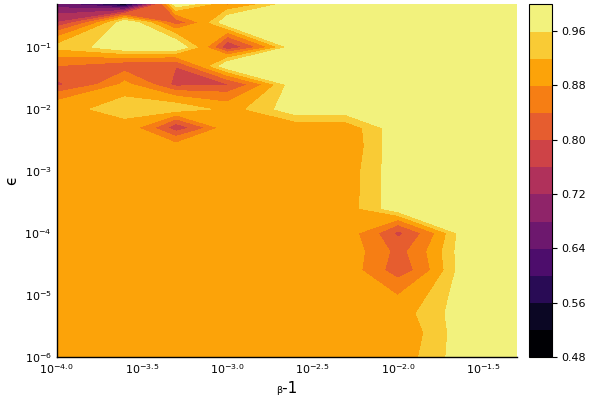

In [76]:
contour(βₗ.-1,ϵₗ,ErrHe, fill = true)
yaxis!("ϵ", :log10)
xaxis!("β-1", :log10)